In [1]:
import sys
quic_path = '/home/quic/QUIC-Projects'
if not quic_path in sys.path:
    sys.path.append(quic_path)

In [2]:
import numpy as np 
from matplotlib import pyplot as plt

In [3]:
from qiskit.algorithms.linear_solvers import NumPyLinearSolver, HHL
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit.utils import QuantumInstance
from qiskit.providers.aer import StatevectorSimulator
from qiskit import transpile

In [4]:
from classifiers.datasets import SklearnDataset
from classifiers.quantum.ansatz import MultilayerCircuit9FeatureMap

In [5]:
gamma = 10**4
iris_dataset = SklearnDataset('iris', feature_range=(-np.pi, np.pi), true_hot=0)

def calculate_hhl_depth(data, label, basis_gate = ['rx', 'ry', 'rz', 'cx']):
    quantum_kernel = QuantumKernel(feature_map=MultilayerCircuit9FeatureMap(4, 2), quantum_instance=StatevectorSimulator())

    kernel_matrix = quantum_kernel.evaluate(data, data)
    kernel_matrix
    F_kernel_matrix = np.matrix(np.vstack((np.hstack([(0,), np.ones(len(label))]), np.hstack((np.ones(len(label)).reshape(-1, 1), kernel_matrix+np.eye(len(label))/gamma)))))
    F_kernel_matrix = F_kernel_matrix/F_kernel_matrix.trace()

    vector = np.hstack(((0,), 2*label-1))
    vector = vector/np.linalg.norm(vector)
    hhl_circuit = HHL().construct_circuit(matrix=F_kernel_matrix, vector=vector, neg_vals=False)
    return transpile(hhl_circuit, basis_gates=basis_gate).depth()

In [6]:
from tqdm.notebook import tqdm

hhl_depths = []
system_size = 2**np.arange(1, 4)
for s in tqdm(system_size):
    X, y = iris_dataset.sample(s-1, return_X_y=True)
    depth = calculate_hhl_depth(X, y)
    hhl_depths.append(depth)

  0%|          | 0/3 [00:00<?, ?it/s]

In [7]:
hhl_depths

[57, 2346, 517755]

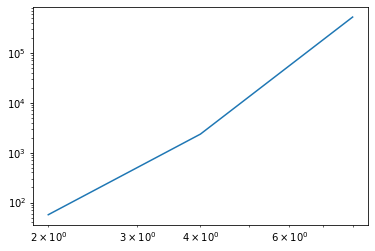

In [11]:
plt.plot(system_size, hhl_depths)
plt.xscale('log')
plt.yscale('log')

<BarContainer object of 150 artists>

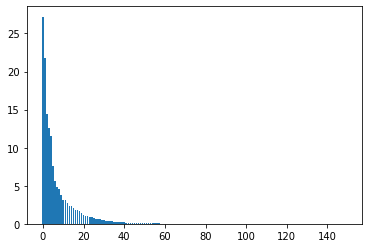

In [33]:
quantum_kernel = QuantumKernel(MultilayerCircuit9FeatureMap(4, 2), 4, quantum_instance=StatevectorSimulator())
kernel = quantum_kernel.evaluate(iris_dataset.sample(150, return_X_y=True)[0])
iris_singular_values = np.linalg.svd(kernel)[1]
plt.bar(x=range(150), height = iris_singular_values)

In [34]:
iris_singular_values[37]/iris_singular_values[0]

0.009177726912539647

In [35]:
iris_singular_values[1]/iris_singular_values[0]

0.8023420093493836

In [36]:
iris_singular_values[2]/iris_singular_values[0]

0.5318184862945976

In [46]:
sum(iris_singular_values[:100])/sum(iris_singular_values)

1.0

In [41]:
15/150

0.1

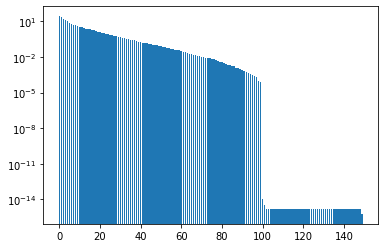

In [45]:
plt.bar(x=range(150), height = iris_singular_values)
plt.yscale('log')